# Fast and Scalable Timeseries Modelling with Fugue and Nixtla

This tutorial will be about scaling time series modelling to Spark, Dask, and Ray. When dealing with large scale data, there are two approaches data scientists can take. The first is training a single model for the whole dataset. This approach illustrates how to train a model for each individual timeseries. There are debates to which approach is better, or even how to combine the two with ensembles. This tutorial is not meant to answer debates on which approach is better, it's just to give a guide how to build the solution for one model per timeseries. 

Timeseries data is very friendly to distributed computing because we normally have hundreds or thousands of relatively independent data points. We can pre-process and model each one independently. This set-up allows choosing the best model for each timeseries. If we have 100 time series, it's very possible that 50 will be better modelled with ARIMA and another 50 will be better modelled with ETS.

This [related article](https://towardsdatascience.com/distributed-forecast-of-1m-time-series-in-under-15-minutes-with-spark-nixtla-and-fugue-e9892da6fd5c) shows the benchmarks of this approach scales to million of timeseries. Training models for one million time series on top of roughly 2000 cpus took below 15 mins. 

The main tools used in this tutorial are:

[Nixtla](https://github.com/Nixtla) - The Nixtla project is focused lightning fast state-of-the-art timeseries modelling. The project has a few libraries
* [statsforecast](https://github.com/Nixtla/statsforecast) - focused on statistic and econometric models such as ARIMA, ETS 
* [neuralforecast](https://github.com/Nixtla/neuralforecast) - neural forecasting algorithms for time series data
* [hierarchicalforecast](https://github.com/Nixtla/hierarchicalforecast) - hierarchichal forecasting with statistical and econometric methods
* [mlforecast](https://github.com/Nixtla/mlforecast) - using models such as gradient boosted trees for forecasting

But for this tutorial, we will focus on statsforecast and hierarchicalforecast.

[Fugue](https://github.com/fugue-project/fugue/) - an abstraction layer for Spark, Dask, and Ray. Fugue ports code written for local execution to distributed execution.

[Dask](https://github.com/dask/dask) on [Coiled](https://www.coiled.io/) - a distributed computing engine built on top of the PyData Stack. The same code can run on top of [Spark](https://github.com/apache/spark) and [Ray](https://github.com/ray-project/ray) just by changing one line of code.


## Goals 

1. Learn how to iterate large scale data effectively
2. Demostrate a distributed model training available for every logical group of data
3. Show some SOTA timeseries forecasting work

Not covered:
1. Time series models for specific use cases (sparse, 0's, irregular)
2. Time series basics like components for ARIMA and ETS models

## Background on Nixtla

Timeseries modeling has been one of the weak points of the Python ecosystem compared to R. Statistical modeling libraries such as [pmdarima](http://alkaline-ml.com/pmdarima/) and [statsmodels](https://www.statsmodels.org/stable/index.html) are orders of magnitude slower than R, and state-of-the-art algorithms remain challenging to implement. The [Nixtla project](https://github.com/Nixtla/) utilizes [numba](https://numba.pydata.org/) to compile Python code to accelerate performance. The highlights of the `statsforecast` library can be found [here](https://github.com/Nixtla/statsforecast#highlights)

![nixtla](../img/nixtla.png)

**ARIMA**
The AutoARIMA model implemented in StatsForecast is 20x faster than [pmdarima](http://alkaline-ml.com/pmdarima/) and 1.5x faster than R while improving accuracy.

**ETS**
StatsForecast’s ETS is 4x faster than [StatsModels’](https://www.statsmodels.org/stable/index.html) and 1.6x faster than R’s, with improved accuracy and robustness.

**Benchmarks at Scale**
With StatsForecast you can fit 9 benchmark models on 1,000,000 series in under 5 min. Reproduce the results [here](https://github.com/Nixtla/statsforecast/tree/main/experiments/benchmarks_at_scale).

## First Look at Nixtla's StatsForecast

We're going to take a quick look at `statsforecast` to understand the form the input data needs to be in. There is a utility function `generate_series` that will create example time series for us to use. 

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
from statsforecast.utils import generate_series

series = generate_series(n_series=2, seed=1)

The time series consist of a `unique_id`, `ds`, the datetime, and `y`, the value being predicted. Because we made two time series in the cell above, the `series` DataFrame will contain two series with unique id values of 0 and 1.

In [3]:
series.head()

,ds,y
unique_id,,
0,2000-01-01,0.360162
0,2000-01-02,1.000057
0,2000-01-03,2.151166
0,2000-01-04,3.073378
0,2000-01-05,4.046169


We'll plot the time series to give a clue of what they look like. Note that they have a different number of measurements. This is acceptable when using `statsforecast`.

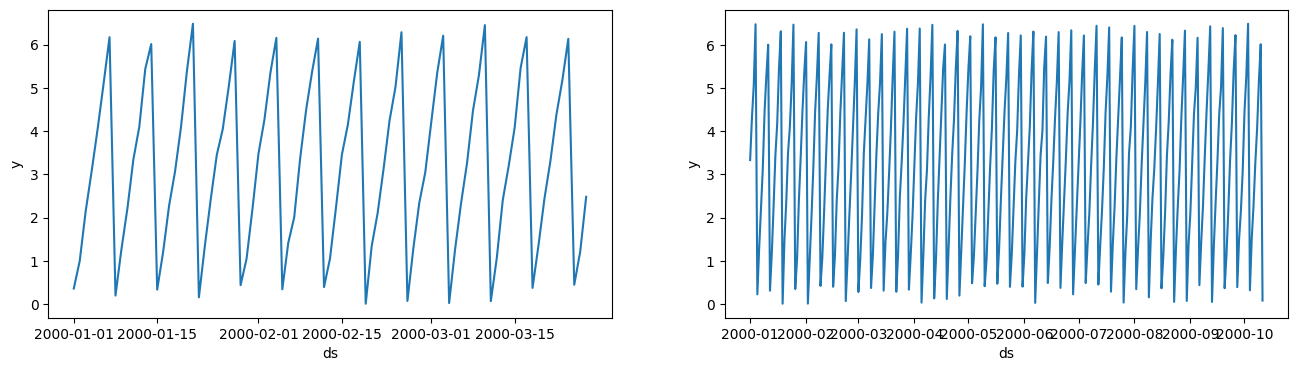

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=2, figsize=(16,4))
series = series.reset_index()
for unique_id in range(2):
    plt.figure()
    _temp = series.loc[series['unique_id'] == unique_id]
    sns.lineplot(x=_temp['ds'], y=_temp['y'], ax=axs[unique_id])

Below is the first introduction to the `statsforecast` syntax. We pass in the DataFrame with the two series that we initially created. We will run the `AutoARIMA` and `AutoETS` models for each time series with default parameters. By default, `AutoETS` is training 15 models and `AutoARIMA` is training 100-something models and getting the best fit. Setting `n_jobs=-1` will triain these models in parallel on the local machine.

Note that the output below is a DataFrame containing the forecasts with a 7 day horizon.

In [5]:
from statsforecast.models import AutoARIMA, AutoETS
from statsforecast.core import StatsForecast

sf = StatsForecast(df=series,
                   models=[AutoARIMA(), AutoETS()], 
                   freq='D', 
                   n_jobs=-1)

forecasts = sf.forecast(7)
forecasts.head()

,ds,AutoARIMA,AutoETS
unique_id,,,
0,2000-03-28,1.953776,3.091089
0,2000-03-29,1.537710,3.728740
0,2000-03-30,1.210246,4.366390
0,2000-03-31,0.952518,5.004040
0,2000-04-01,0.749675,5.641691


The code below is just to visualize the forecasts. The forecasts may look off because of the fake data and default model parameters, but it will look more reasonable with some tuning on real data.

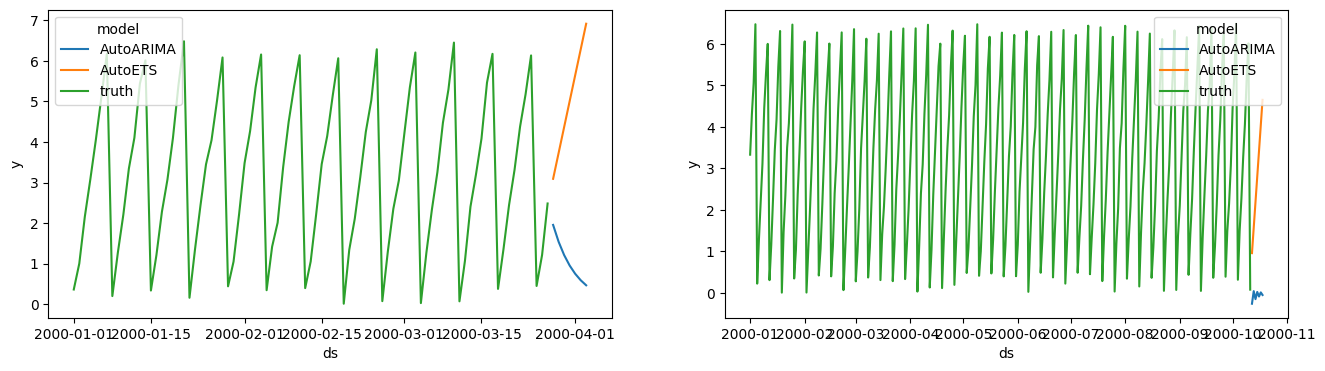

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [6]:
fig, axs = plt.subplots(ncols=2, figsize=(16,4))
combined = pd.concat(
    [forecasts.reset_index().melt(id_vars=["unique_id","ds"]).rename(columns={"variable":"model", "value": "y"}),
    series.assign(model="truth")]
    , axis=0, ignore_index=True)

for unique_id in range(2):
    plt.figure()
    _temp = combined.loc[combined['unique_id'] == unique_id]
    sns.lineplot(x=_temp['ds'], y=_temp['y'], hue=_temp['model'], ax=axs[unique_id])

## Fit-Predict Interface

With classical machine learning models, it's a very common approach to save the model weights with something like `pickle` to be loaded during prediction time. This is less common for timeseries modelling because the focus is on a lightweight combined train-predict operation when predictions are needed. This is what the `StatsForecast.forecast()` method does.

Still, Nixtla has a `scikit-learn` type `fit-predict()` interface. Below is what it would look like.

In [7]:
model = StatsForecast(df=series,
                      models=[AutoARIMA(), AutoETS()], 
                      freq='D', 
                      n_jobs=-1)
model.fit()

StatsForecast(models=[AutoARIMA,AutoETS])

The `predict()` method will just take in a horizon. Each of the fitted models will be used to generate predictions.

In [8]:
model.predict(h=7)

,ds,AutoARIMA,AutoETS
unique_id,,,
0,2000-03-28,1.953776,3.091089
0,2000-03-29,1.537710,3.728740
0,2000-03-30,1.210246,4.366390
0,2000-03-31,0.952518,5.004040
0,2000-04-01,0.749675,5.641691
0,2000-04-02,0.590028,6.279341
0,2000-04-03,0.464378,6.916991
1,2000-10-12,-0.259481,0.959451
1,2000-10-13,0.044271,1.575038


After the fitting, the `StatsForecast` object will contain the fitted models for each unique id. Note that you can't train on one timeseries A, and predict on a different timeseries B (yet). The model is timeseries specific.

In [9]:
model.fitted_

array([[AutoARIMA, AutoETS],
       [AutoARIMA, AutoETS]], dtype=object)

The weights for each of the fitted models for each timeseries in the class will be held. Because of this, it can be computationally expensive to fit a lot of models on each timeseries. This is why a direct `forecast()` is preferred to the separated `fit()-predict()` in a lot of cases. It can significantly reduce overhead.

In [10]:
model.fitted_[0][0].model_

{'coef': {'ar1': 0.7870449304023962},
 'sigma2': 5.325976316316542,
 'var_coef': array([[0.00012343]]),
 'mask': array([ True]),
 'loglik': -195.6769619985521,
 'aic': 395.3539239971042,
 'arma': (1, 0, 0, 0, 1, 0, 0),
 'residuals': array([ 0.22218254,  0.71659334,  1.36407624,  1.3803134 ,  1.62728283,
         1.90861309,  2.16425828, -4.65987188,  1.11327143,  1.21051595,
         1.60355725,  1.47144228,  2.2104224 ,  1.73291017, -4.39781348,
         0.94480836,  1.32808107,  1.27624676,  1.68267027,  2.17423557,
         2.23379506, -4.94659024,  1.22282191,  1.37870504,  1.52833466,
         1.32933937,  1.83788103,  2.13432154, -4.35003039,  0.70360468,
         1.38480722,  1.73913955,  1.52849664,  1.98794656,  1.95026382,
        -4.50318157,  1.14715933,  0.89365517,  1.79378559,  1.83809705,
         1.83676427,  1.91057726, -4.43799098,  0.74101382,  1.39628015,
         1.70395172,  1.42811964,  1.88016394,  2.01654377, -4.76375533,
         1.33179648,  1.05163198,  1.4

## FugueBackend to Run on Spark, Dask, and Ray

Using the same syntax, we can bring the training of the time series models on top of Spark, Dask or Ray. Nixtla has a native integration with the [Fugue](https://github.com/fugue-project/fugue/) project, allowing it to distribute the training jobs by just supplying a backend.

Spark, Dask, and Ray DataFrames don't support indexes in the same way Pandas DataFrames do. Because of this, we need to call `reset_index()` and have `unique_id` as a column of the DataFrame when bringing the forecasting to Spark, Dask, or Ray.

In [11]:
series = generate_series(n_series=50, seed=1).reset_index()
series

,unique_id,ds,y
0,0,2000-01-01,0.296533
1,0,2000-01-02,1.335827
2,0,2000-01-03,2.205894
3,0,2000-01-04,3.098775
4,0,2000-01-05,4.144815
...,...,...,...
14087,49,2000-03-16,3.429861
14088,49,2000-03-17,4.191251
14089,49,2000-03-18,5.358637
14090,49,2000-03-19,6.100164


Now all we have to do is create a `FugueBackend` and pass in an execution engine. There are more detailed instructions on how to define execution engines in the [tutorials](https://fugue-tutorials.readthedocs.io/tutorials/quick_look/ten_minutes.html#execution-engines). In this example, we are creating a Dask cluster and passing the `Client` as the backend. The `FugueBackend` can also use Spark or Ray. For Spark, users can pass a SparkSession. For Ray, it will be the string `"ray"`.

```python
# Defining engine for Spark and Ray
backend = FugueBackend(spark_session)    # Spark
backend = FugueBackend("ray")            # Ray
```

In [12]:
from dask.distributed import Client, LocalCluster
from statsforecast.distributed.utils import forecast
from statsforecast.distributed.fugue import FugueBackend

cluster = LocalCluster(threads_per_worker=1)
client = Client(cluster)

backend = FugueBackend(client)

result = forecast(series, 
                  models=[AutoARIMA(), AutoETS()], 
                  freq="D", 
                  h=7, 
                  parallel=backend)

The `result` here will be a Dask DataFrame because Dask was used as the engine.

In [13]:
type(result)

dask.dataframe.core.DataFrame

Dask, and other distributed backends, evaluate lazily. Here we explicitly call `.compute()`, which is a Dask method to trigger the execution. Spark and Ray will have equivalent methods, or calling an action will also trigger the execution.

In [ ]:
result.compute().head()

,unique_id,ds,AutoARIMA
0,31,2000-05-16,3.222850
1,31,2000-05-17,3.222849
2,31,2000-05-18,3.222849
3,31,2000-05-19,3.222849
4,31,2000-05-20,3.222849


## Conclusion

Now that we know how to use `StatsForecast`, we'll apply this on a real dataset. Also, the above syntax has a limitation in that we can't get evaluation metrics or save the models. In short, we can't inject custom code. We will explore this application in the next sections.